In [136]:
from kornia.color.hsv import rgb_to_hsv, hsv_to_rgb
import cv2

In [17]:
# original code
# Implementations for different image transformation used for data augmentation
import torch
import torch.nn as nn
import torch.nn.functional as F


class RandomShiftsAug(nn.Module):
    def __init__(self, pad):
        super().__init__()
        self.pad = pad

    def forward(self, x):
        n, c, h, w = x.size()
        assert h == w
        padding = tuple([self.pad] * 4)
        x = F.pad(x, padding, 'replicate')
        eps = 1.0 / (h + 2 * self.pad)
        arange = torch.linspace(-1.0 + eps,
                                1.0 - eps,
                                h + 2 * self.pad,
                                device=x.device,
                                dtype=x.dtype)[:h]
        arange = arange.unsqueeze(0).repeat(h, 1).unsqueeze(2)
        base_grid = torch.cat([arange, arange.transpose(1, 0)], dim=2)
        base_grid = base_grid.unsqueeze(0).repeat(n, 1, 1, 1)

        shift = torch.randint(0,
                              2 * self.pad + 1,
                              size=(n, 1, 1, 2),
                              device=x.device,
                              dtype=x.dtype)
        shift *= 2.0 / (h + 2 * self.pad)

        grid = base_grid + shift
        return F.grid_sample(x,
                             grid,
                             padding_mode='zeros',
                             align_corners=False)


class DataAug(nn.Module):
    def __init__(self, da_type):
        super().__init__()
        self.data_aug_type = da_type
        if self.data_aug_type == 1:
            # random shift
            self.aug = RandomShiftsAug(4)

    def forward(self, x):
        return self.aug(x)

In [73]:
# load sample data
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
sample_data = CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
sample_dataloader = DataLoader(sample_data, batch_size=64, shuffle=True)
for X, y in sample_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

100%|██████████| 170498071/170498071 [01:04<00:00, 2637530.09it/s]


Extracting data\cifar-10-python.tar.gz to data
Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32])
Shape of y:  torch.Size([64]) torch.int64


In [83]:
import matplotlib.pyplot as plt
def compare_sample(img_tensor1, img_tensor2, cmap=None):
    _, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[1].axis("off")
    transform = (lambda x: x.permute(1, 2, 0)) if cmap ==  None else (lambda x: x.squeeze())
    ax[0].imshow(transform(img_tensor1), cmap=cmap)
    ax[1].imshow(transform(img_tensor2), cmap=cmap)
def compare_aug(dataloader, aug):
    for X, _ in dataloader:
        original_X = X
        auged_X = aug(X)
    compare_sample(original_X[0], auged_X[0])

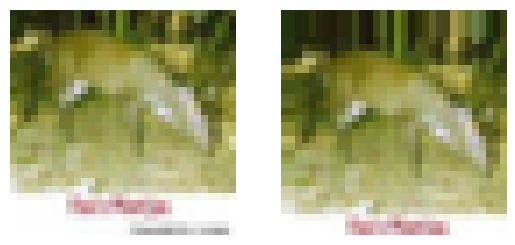

In [90]:
compare_aug(sample_dataloader, DataAug(1))

In [133]:
class RandomShearingAug(nn.Module):
    def __init__(self, direction="horizontal", magnitude_interval=(-1, 1)):
        super().__init__()
        self.direction = direction
        self.magnitude_interval = magnitude_interval

    def forward(self, x):
        n = x.size(0)
        shear_factor = torch.rand(1, device=x.device, dtype=x.dtype).item() * (
            self.magnitude_interval[1] - self.magnitude_interval[0]
        ) + self.magnitude_interval[0]
        shear_tensor = (
            torch.tensor([[1, shear_factor, 0], [0, 1, 0]], device=x.device)
            if self.direction == "horizontal"
            else torch.tensor([[1, 0, 0], [shear_factor, 1, 0]], device=x.device)
        )

        sheared = F.affine_grid(
            shear_tensor.repeat(n, 1, 1),
            x.size(),
            align_corners=False,
        )
        return F.grid_sample(x, sheared, align_corners=False, padding_mode="zeros")

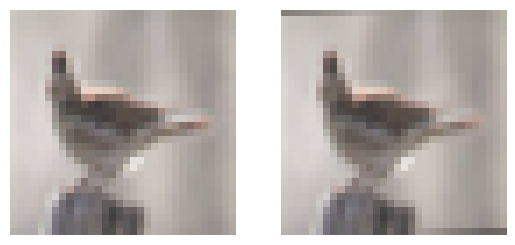

In [134]:
compare_aug(sample_dataloader, RandomShearingAug("vertical", (-0.3, 0.3)))

In [100]:
class RandomNoiseInjectionAug(nn.Module):
    def __init__(self, magnitude_interval=(0, 0.1), float_tensor=True):
        super().__init__()
        self.magnitude_interval = magnitude_interval
        self.float_tensor = float_tensor

    def forward(self, x):
        noise = (
            torch.rand_like(x, device=x.device, dtype=x.dtype)
            * (self.magnitude_interval[1] - self.magnitude_interval[0])
            + self.magnitude_interval[0]
        ) if self.float_tensor else (
            torch.randint_like(x, self.magnitude_interval[0], self.magnitude_interval[1])
        )
        return (x + noise).clamp(0, 1 if self.float_tensor else 255).to(x.dtype)

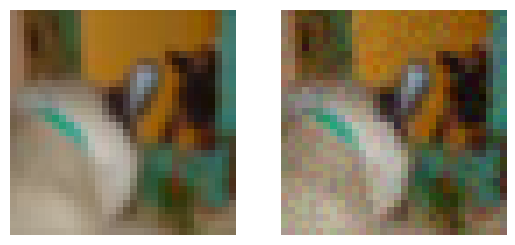

In [101]:
compare_aug(sample_dataloader, RandomNoiseInjectionAug((-0.05, 0.05)))

In [97]:
class RandomColorShiftingAug(nn.Module):
    def __init__(self, magnitude_interval=(0, 0.1), float_tensor=True):
        super().__init__()
        self.magnitude_interval = magnitude_interval
        self.float_tensor = float_tensor

    def forward(self, x):
        shift = (
            torch.rand(1, device=x.device, dtype=x.dtype)
            * (self.magnitude_interval[1] - self.magnitude_interval[0])
            + self.magnitude_interval[0]
        ).item() if self.float_tensor else (
            torch.randint(self.magnitude_interval[0], self.magnitude_interval[1], (1,))
        ).item()
        return (x + shift).clamp(0, 1 if self.float_tensor else 255).to(x.dtype)

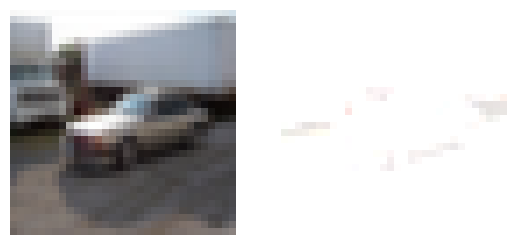

In [108]:
compare_aug(sample_dataloader, RandomColorShiftingAug((0.8,0.9)))

In [102]:
class RandomColorScalingAug(nn.Module):
    def __init__(self, magnitude_interval=(0, 1), float_tensor=True):
        super().__init__()
        self.magnitude_interval = magnitude_interval
        self.float_tensor = float_tensor

    def forward(self, x):
        scale = (
            torch.rand(1, device=x.device, dtype=x.dtype)
            * (self.magnitude_interval[1] - self.magnitude_interval[0])
            + self.magnitude_interval[0]
        ).item()
        result = (x * scale).clamp(0, 1 if self.float_tensor else 255)
        if self.float_tensor:
            return result
        else:
            return result.round().to(x.dtype)

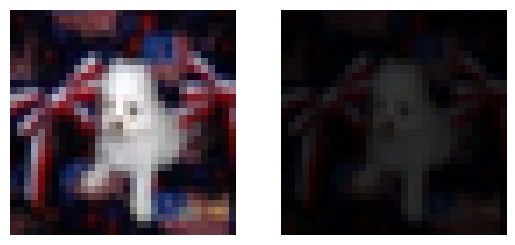

In [121]:
compare_aug(sample_dataloader, RandomColorScalingAug((0.2, 0.21)))

In [106]:
class ColorInversionAug(nn.Module):
    def __init__(self, float_tensor=True):
        super().__init__()
        self.float_tensor = float_tensor

    def forward(self, x):
        color_max = 1 if self.float_tensor else 255
        return (color_max - x).to(x.dtype)

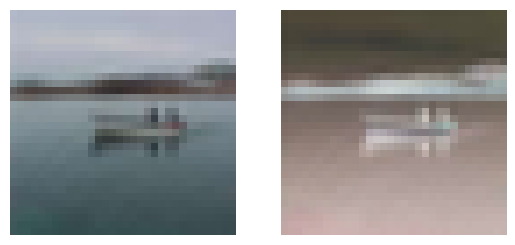

In [107]:
compare_aug(sample_dataloader, ColorInversionAug())

In [117]:
class RandomHueShiftingAug(nn.Module):
    def __init__(self, magnitude_interval=(0, 0.1), float_tensor=True):
        super().__init__()
        self.magnitude_interval = magnitude_interval
        self.float_tensor = float_tensor

    def forward(self, x):
        hsv = rgb_to_hsv(x) if self.float_tensor else rgb_to_hsv(x / 255)
        shift = (
            torch.rand(1, device=x.device, dtype=x.dtype)
            * (self.magnitude_interval[1] - self.magnitude_interval[0])
            + self.magnitude_interval[0]
        ).item()
        hsv[:, 0, :, :] = (hsv[:, 0, :, :] + shift) % 1
        return (
            hsv_to_rgb(hsv) if self.float_tensor else (hsv_to_rgb(hsv) * 255).round()
        ).to(x.dtype)

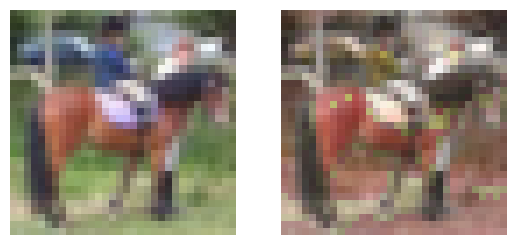

In [118]:
compare_aug(sample_dataloader, RandomHueShiftingAug((0.8, 0.9)))

In [119]:
class RandomSaturationScalingAug(nn.Module):
    def __init__(self, magnitude_interval=(0, 0.1), float_tensor=True):
        super().__init__()
        self.magnitude_interval = magnitude_interval
        self.float_tensor = float_tensor

    def forward(self, x):
        hsv = rgb_to_hsv(x) if self.float_tensor else rgb_to_hsv(x / 255)
        scale = (
            torch.rand(1, device=x.device, dtype=x.dtype)
            * (self.magnitude_interval[1] - self.magnitude_interval[0])
            + self.magnitude_interval[0]
        ).item()
        hsv[:, 1, :, :] = (hsv[:, 1, :, :] * scale) % 1
        return (
            hsv_to_rgb(hsv) if self.float_tensor else (hsv_to_rgb(hsv) * 255).round()
        ).to(x.dtype)

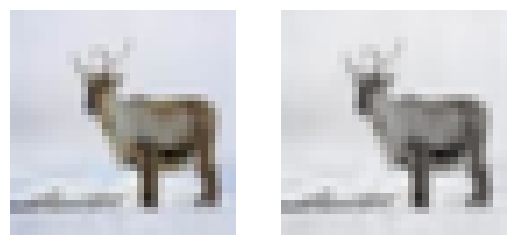

In [120]:
compare_aug(sample_dataloader, RandomSaturationScalingAug((0.2, 0.21)))

In [155]:
class KernelAug(nn.Module):
    def __init__(self, kernel, float_tensor=True):
        super().__init__()
        self.kernel = kernel
        self.float_tensor = float_tensor

    def forward(self, x):
        kernel = self.kernel.to(x.device).to(x.dtype)
        c = x.size(1)
        conved = F.conv2d(x, kernel.repeat(c, 1, 1, 1), padding=kernel.size(0) // 2, groups=c)
        conved = conved if self.float_tensor else conved.round()
        return conved.clamp(0, 1 if self.float_tensor else 255).to(x.dtype)
    
class GaussianBlurAug(KernelAug):
    def __init__(self, kernel_size=3, sigma=1, float_tensor=True):
        kernel = torch.tensor(
            cv2.getGaussianKernel(kernel_size, sigma),
            dtype=torch.float32,
        )
        kernel = kernel @ kernel.t()
        super().__init__(kernel, float_tensor)

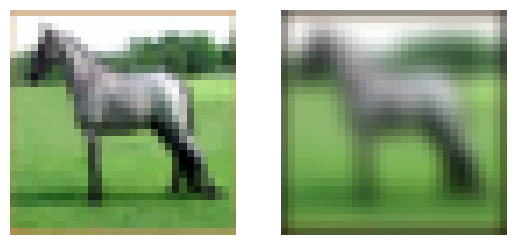

In [156]:
compare_aug(sample_dataloader, GaussianBlurAug(5, 1.5))

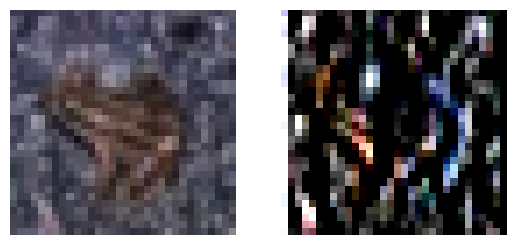

In [158]:
compare_aug(
    sample_dataloader, KernelAug(torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
)